In [15]:
import numpy as np 
import pandas as pd 

import os
import time
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from torch.optim import Adam
from torch import nn

from sklearn.metrics import classification_report
from torch.utils.data import random_split

%matplotlib inline

! pip install -q imutils
from imutils import paths
import shutil
from urllib.request import urlopen
from PIL import Image

# 1. Loading and Visualizing data

In [48]:
# Initializing parameters 

PATH = '/kaggle/input/asl-dataset/asl_dataset/asl_dataset'
SAVE_PATH = ""
PLOT_PATH = ""
INPUT_HEIGHT = 299
INPUT_WIDTH  = 299

TRAIN = "train"
VAL = "val"

BATCH_SIZE = 8
VAL_SPLIT  = 0.15
EPOCHS = 20
LR = 1e-3
model_name = "mobilenet" #vgg16,mobilenet,inceptionv3


In [17]:
def copy_images(imagePaths, folder):
    
    # Creating destination folder
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    # loop over the image paths
    for path in imagePaths:
        # Fetching name and label if the image and saving the files in training and validation folders
        imageName = path.split('/')[-1]
        label = path.split('/')[-2]
        labelFolder = os.path.join(folder, label)
        
        # Creating labelfolder if it doesn't exits
        if not os.path.exists(labelFolder):
            os.makedirs(labelFolder)
            
        # construct the destination image path and copy the current image to it
        destination = os.path.join(labelFolder, imageName)
        shutil.copy(path, destination)

In [18]:
# load all the image paths and randomly shuffle them

print(">>> Loading Image paths...\n")

imagePaths = list(paths.list_images(PATH))
np.random.shuffle(imagePaths)

# Generating train & val paths

valPathsLen = int(len(imagePaths) * VAL_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen

trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:]

# Copying the training and validation images to their respective directories using the function above

print(">>> Copying training and validation images...")
copy_images(trainPaths, TRAIN)
copy_images(valPaths, VAL)

>>> Loading Image paths...

>>> Copying training and validation images...


In [19]:
def visualize_batch(batch, classes, dataset_type):
    
    fig = plt.figure("{} batch".format(dataset_type), figsize=(BATCH_SIZE, BATCH_SIZE))
    
    # Looping over the batch size
    for i in range(0, BATCH_SIZE):
        
        # Creating a subplot
        ax = plt.subplot(int(BATCH_SIZE/4), int(BATCH_SIZE/2), i + 1)
        
        '''grab the image, convert it from channels first ordering to
        channels last ordering, and scale the raw pixel intensities
        to the range [0, 255]'''
        
        image = batch[0][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")
        
        # grab the label id and get the label from the classes list
        idx = batch[1][i]
        label = classes[idx]
        
        # show the image along with the label
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")
        
    # show the plot
    plt.tight_layout()
    plt.show()

In [20]:
# Initializing our transformations & augmentations

resize = transforms.Resize(size=(INPUT_HEIGHT, INPUT_WIDTH))

In [21]:
# Initializing our training and validation set data augmentation pipeline

trainTransforms = transforms.Compose([resize, transforms.ToTensor()])
valTransforms = transforms.Compose([resize, transforms.ToTensor()])

In [22]:
# initialize the training and validation dataset

print(">>> Loading the training and validation dataset...\n")

trainDataset = ImageFolder(root = TRAIN, transform = trainTransforms)
valDataset = ImageFolder(root = VAL, transform = valTransforms)

print(">>> Training dataset contains {} samples...".format(len(trainDataset)))
print(">>> Validation dataset contains {} samples...".format(len(valDataset)))

>>> Loading the training and validation dataset...

>>> Training dataset contains 2462 samples...
>>> Validation dataset contains 701 samples...


In [23]:
# create training and validation set dataloaders

print(">>> Creating training and validation set dataloaders...")

trainDataLoader = DataLoader(trainDataset, batch_size = BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size = BATCH_SIZE)

>>> Creating training and validation set dataloaders...


In [24]:
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [25]:
from torchvision import models
def create_inceptionv3():
    inception_v3 = models.inception_v3(pretrained=True)
    for param in inception_v3.parameters():
        param.requires_grad = False

    num_ftrs = inception_v3.AuxLogits.fc.in_features
    inception_v3.AuxLogits.fc = nn.Linear(num_ftrs, len(trainDataLoader.dataset.classes))

    num_ftrs = inception_v3.fc.in_features
    inception_v3.fc = nn.Linear(num_ftrs, len(trainDataLoader.dataset.classes))

    inception_v3 = inception_v3.to(device)
    return inception_v3

In [42]:
def create_vgg():
    vgg16 = models.vgg16(pretrained=True)
    for param in vgg16.parameters():
        param.requires_grad = False

    # Modify the last fully connected layer (classifier[6]) for the desired number of classes
    num_ftrs = vgg16.classifier[6].in_features
    vgg16.classifier[6] = nn.Linear(num_ftrs, len(trainDataLoader.dataset.classes))

    vgg16 = vgg16.to(device)
    return vgg16

In [52]:
def create_mobilenet():
    # Load the pre-trained MobileNetV2 model
    mobilenet_v2 = models.mobilenet_v2(pretrained=True)

    # Disable gradient computation for pre-trained layers
    for param in mobilenet_v2.parameters():
        param.requires_grad = False

    # Modify the final fully connected layer for classification
    num_ftrs = mobilenet_v2.classifier[1].in_features
    mobilenet_v2.classifier[1] = nn.Linear(num_ftrs, len(trainDataLoader.dataset.classes))

    mobilenet_v2 = mobilenet_v2.to(device)
    return mobilenet_v2

In [53]:
model_dict = {"inceptionv3":create_inceptionv3,"vgg16":create_vgg,"mobilenet":create_mobilenet}
print(">>> Initializing the  model...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_dict[model_name]()


opt = Adam(model.parameters(), lr=LR)
lossFn = nn.CrossEntropyLoss()  

H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
     }

print(">>> Training the network...")
startTime = time.time()

>>> Initializing the  model...
>>> Training the network...


In [54]:
for e in range(0, EPOCHS):
    
    # Training
    model.train()

    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0

    for (x, y) in trainDataLoader:

        (x, y) = (x.to(device), y.to(device))
        if(model_name == "inceptionv3"):
            pred,_ = model(x)
        else:
            pred = model(x)
        #pred = pred.argmax(1)
        loss = lossFn(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    # Evaluation
    with torch.no_grad():

        model.eval()

        for (x, y) in valDataLoader:

            (x, y) = (x.to(device), y.to(device))

            pred = model(x)
            #pred = pred.argmax(1)
            totalValLoss += lossFn(pred, y)

            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculating the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    # Calculating the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDataLoader.dataset) # like correcct/total
    valCorrect = valCorrect / len(valDataLoader.dataset)
 
    # Updating training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
 
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))

[INFO] EPOCH: 1/20
Train loss: 2.460751, Train accuracy: 0.3647
Val loss: 1.145603, Val accuracy: 0.8117

[INFO] EPOCH: 2/20
Train loss: 1.152032, Train accuracy: 0.7226
Val loss: 0.653170, Val accuracy: 0.8631

[INFO] EPOCH: 3/20
Train loss: 0.783240, Train accuracy: 0.8168
Val loss: 0.435478, Val accuracy: 0.9301

[INFO] EPOCH: 4/20
Train loss: 0.581916, Train accuracy: 0.8578
Val loss: 0.283902, Val accuracy: 0.9529

[INFO] EPOCH: 5/20
Train loss: 0.471559, Train accuracy: 0.8846
Val loss: 0.216486, Val accuracy: 0.9643

[INFO] EPOCH: 6/20
Train loss: 0.395328, Train accuracy: 0.9033
Val loss: 0.215491, Val accuracy: 0.9629

[INFO] EPOCH: 7/20
Train loss: 0.361241, Train accuracy: 0.9110
Val loss: 0.173771, Val accuracy: 0.9729

[INFO] EPOCH: 8/20
Train loss: 0.338661, Train accuracy: 0.9127
Val loss: 0.125428, Val accuracy: 0.9843

[INFO] EPOCH: 9/20
Train loss: 0.290008, Train accuracy: 0.9285
Val loss: 0.132270, Val accuracy: 0.9757

[INFO] EPOCH: 10/20
Train loss: 0.276321, Trai

In [55]:
torch.save(model,os.path.join(SAVE_PATH,model_name+".pth"))
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

Total time taken to train the model: 399.71s


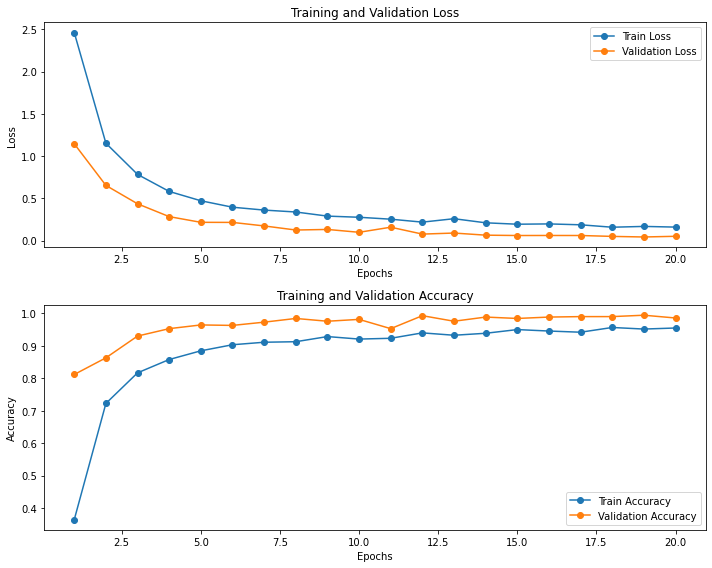

In [56]:
# Assuming H["train_loss"], H["train_acc"], H["val_loss"], and H["val_acc"] contain the data
train_loss = H["train_loss"]
train_acc = H["train_acc"]
val_loss = H["val_loss"]
val_acc = H["val_acc"]

# Create a list of epochs (x-axis values)
epochs = list(range(1,EPOCHS+1))

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))

# Plot training and validation loss
ax1.plot(epochs, train_loss, label="Train Loss", marker='o', linestyle='-')
ax1.plot(epochs, val_loss, label="Validation Loss", marker='o', linestyle='-')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot training and validation accuracy
ax2.plot(epochs, train_acc, label="Train Accuracy", marker='o', linestyle='-')
ax2.plot(epochs, val_acc, label="Validation Accuracy", marker='o', linestyle='-')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.savefig(os.path.join(PLOT_PATH,model_name+'_plot.png')) 
plt.tight_layout()
plt.show()